In [26]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [1]:
import numpy as np
import pandas as pd
import os
import keras
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import glob

2022-12-23 16:59:19.445227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-23 16:59:19.509154: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-23 16:59:19.511306: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64
2022-12-23 16:59:19.511313: I tensorflow/compiler/xla/stream

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2022-12-23 16:59:22.800170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 16:59:22.800705: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tienthinh/.local/lib/python3.8/site-packages/cv2/../../lib64::/usr/local/cuda/lib64
2022-12-23 16:59:22.800841: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/tienthinh/.local/lib/python3.8/site-packages/cv2/../../lib64::/usr/local/cuda/lib64
2022-12-23 16:59:22.800954: W tensorflow/compiler/xla/stream_executor

In [3]:
train_dir = 'data/asl_alphabet_train'
test_dir = 'data/asl_alphabet_test/'
IMG_SIZE = 256,256

In [4]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(   
    directory=train_dir,
    label_mode="categorical",
    color_mode="rgb",
    image_size=IMG_SIZE,
    seed=40,
    batch_size=256,
    validation_split=0.2,
    subset='training'
)

val_data = tf.keras.preprocessing.image_dataset_from_directory( 
    directory=train_dir,
    label_mode="categorical",
    color_mode="rgb",
    image_size=IMG_SIZE,
    seed=40,
    validation_split=0.2,
    batch_size=256,
    subset='validation',
    interpolation="bilinear"
)

Found 223074 files belonging to 29 classes.
Using 178460 files for training.


2022-12-23 16:59:32.266918: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 223074 files belonging to 29 classes.
Using 44614 files for validation.


In [22]:
input_shape = (256, 256, 3)
base_model = tf.keras.applications.ResNet50(include_top=False)
base_model.trainable = False

# Tạo layer đầu vào
inputs = Input(shape=input_shape, name="input_layer")

# Thêm vào mô hình tuần tự tăng cường dữ liệu dưới dạng layer
x = data_augmentation(inputs)

# Cung cấp đầu vào cho base_model (sau khi tăng cường) và không huấn luyện nó 
x = base_model(x, training=False)

# Gộp các đặc trưng đầu ra của base model
x = GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
# x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

# x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
#                 bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x = Dense(256)(x)
x = Dropout(rate=.4)(x)  

# Đặt dense layer làm đầu ra
outputs = Dense(29, activation="softmax", name="output_layer")(x)

# Tạo mô hình với đầu vào và đầu ra
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 256, 256, 3)      0         
 al)                                                             
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling_laye  (None, 2048)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.005),loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=8, verbose=1)
callbacks_list = [early_stopping]

In [25]:
model_hist = model.fit(train_data,validation_data = val_data, epochs = 60, callbacks=callbacks_list)

Epoch 1/60
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
  3/698 [..............................] - ETA: 1:10:30 - loss: 14.3042 - accuracy: 0.0599Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/tienthinh/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_7623/2452771273.py", line 1, in <module>
    model_hist = model.fit(train_data,validation_data = val_data, epochs = 60, callbacks=callbacks_list)
  File "/home/tienthinh/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
    try:
  File "/home/tienthinh/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
    `tf.distribute.experimental.ParameterServerStrategy`.
  File "/home/tienthinh/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/home/tienthinh/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py", line 915, in __call__
  File "/home/tienthinh/anaconda3/lib/py

In [10]:
model.save('model_resnet50.h5')

/home/tienthinh/.local/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


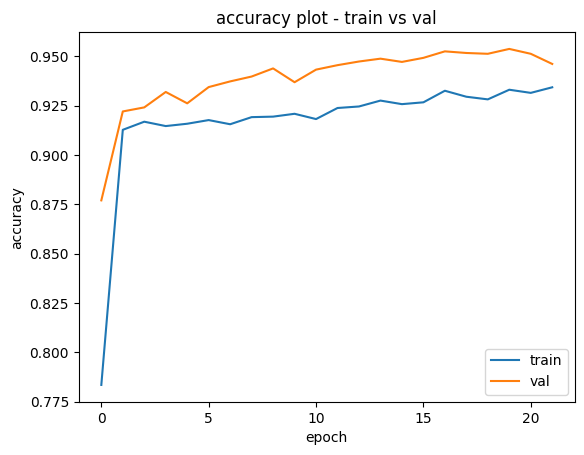

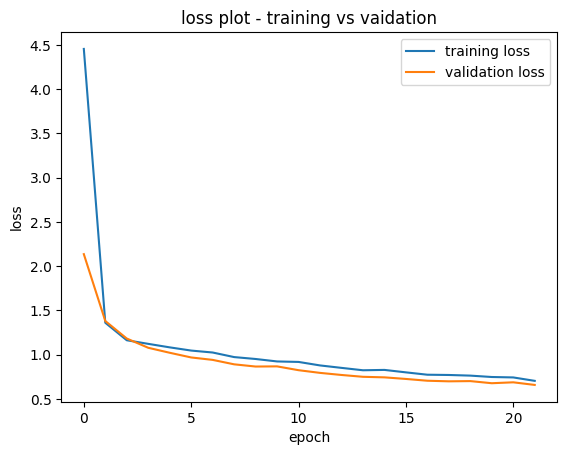

In [17]:
plt.plot(model_hist.history['accuracy'])
plt.plot(model_hist.history['val_accuracy'])
plt.legend(['train', 'val'], loc='lower right')
plt.title('accuracy plot - train vs val')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs vaidation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [10]:
test_data = tf.keras.preprocessing.image_dataset_from_directory( 
    directory=test_dir,
    label_mode="categorical",
    color_mode="rgb",
    image_size=IMG_SIZE,
    batch_size=256,
)

Found 2700 files belonging to 27 classes.


In [11]:
test_metrics = model.evaluate(test_data)
print("\nTesting Accuracy = ", "{:.2f}%".format(test_metrics[1]*100),"\nEvaluation loss = " ,"{:.6f}".format(test_metrics[0]))

11/11 [==============================] - 64s 6s/step - loss: 0.6554 - accuracy: 0.9493

Testing Accuracy =  94.93% 
Evaluation loss =  0.655441


In [13]:
labels = []
predicts = []
for image, label in test_data.unbatch():
    predict = np.argmax(np.squeeze(model.predict(image.numpy().reshape(1,256,256,3))))
    predicts.append(predict)
    labels.append(np.argmax(label))

predicts = np.array(predicts)
labels = np.array(labels)

In [14]:
labels

array([22,  3, 12, ..., 25, 17, 26])

Confusion matrix, without normalization


<Figure size 2000x2000 with 0 Axes>

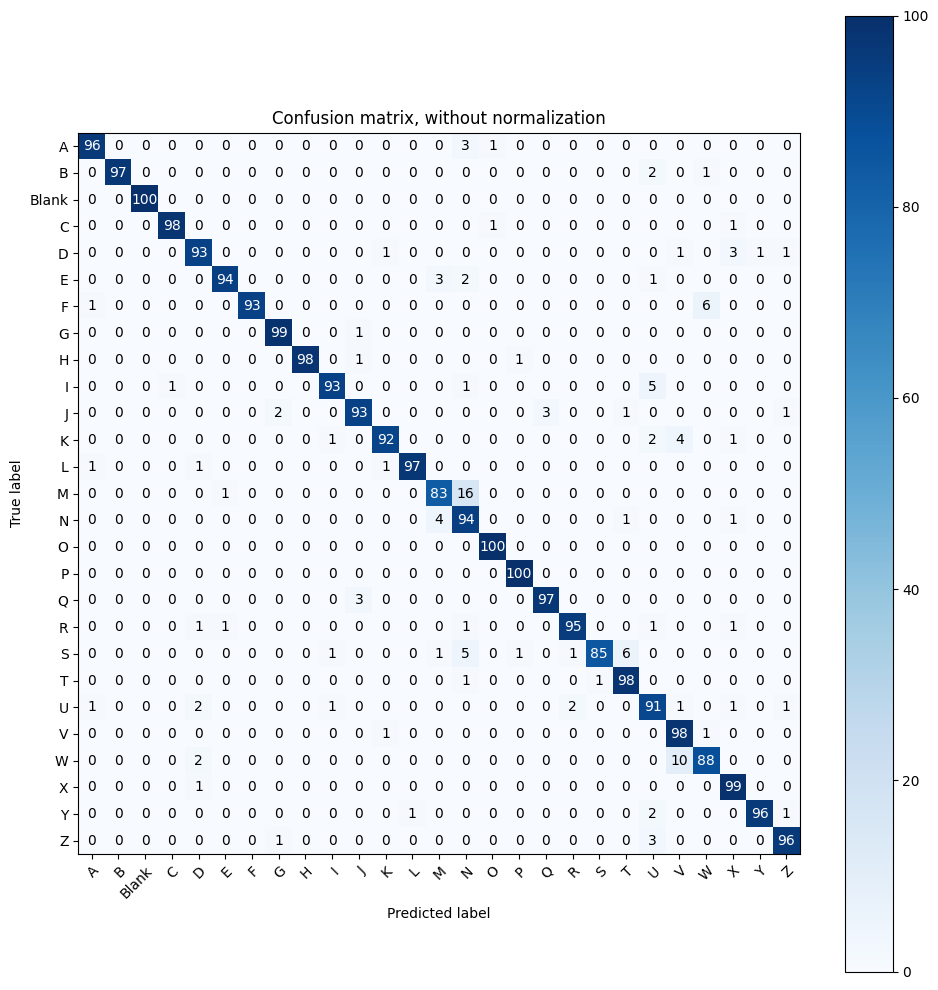

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = metrics.confusion_matrix(labels, predicts)
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Visualizing
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

#Non-Normalized Confusion Matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(labels, predicts, classes = train_data.class_names)
plt.show()

In [16]:
from sklearn.metrics import classification_report
print(classification_report(labels, predicts))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       100
           1       1.00      0.97      0.98       100
           2       1.00      1.00      1.00       100
           3       0.99      0.98      0.98       100
           4       0.93      0.93      0.93       100
           5       0.98      0.94      0.96       100
           6       1.00      0.93      0.96       100
           7       0.97      0.99      0.98       100
           8       1.00      0.98      0.99       100
           9       0.97      0.93      0.95       100
          10       0.95      0.93      0.94       100
          11       0.97      0.92      0.94       100
          12       0.99      0.97      0.98       100
          13       0.91      0.83      0.87       100
          14       0.76      0.94      0.84       100
          15       0.98      1.00      0.99       100
          16       0.98      1.00      0.99       100
          17       0.97    

**Test with my data**

In [5]:
class_names = train_data.class_names

In [6]:
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [29]:
test_prediction = []
for i in glob.glob('myself/*'):
    image = keras.preprocessing.image.load_img(
        i, grayscale=False, color_mode="rgb", target_size=(256,256), interpolation="bilinear"
    )
    input_arr = keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    predict = np.argmax(model.predict(input_arr))
    test_prediction.append(class_names[predict])

In [31]:
def load_test_data(folder):
    images = []
    names = []
    size = 256,256
    for image in os.listdir(folder):
        temp = cv2.imread(folder + '/' + image)
        temp = cv2.resize(temp, size)
        temp = cv2.cvtColor(temp,cv2.COLOR_BGR2RGB)
        images.append(temp)
        names.append(image)
    images = np.array(images)
    return images, names

test_images, test_img_names = load_test_data('myself')

IndexError: index 26 is out of bounds for axis 0 with size 26

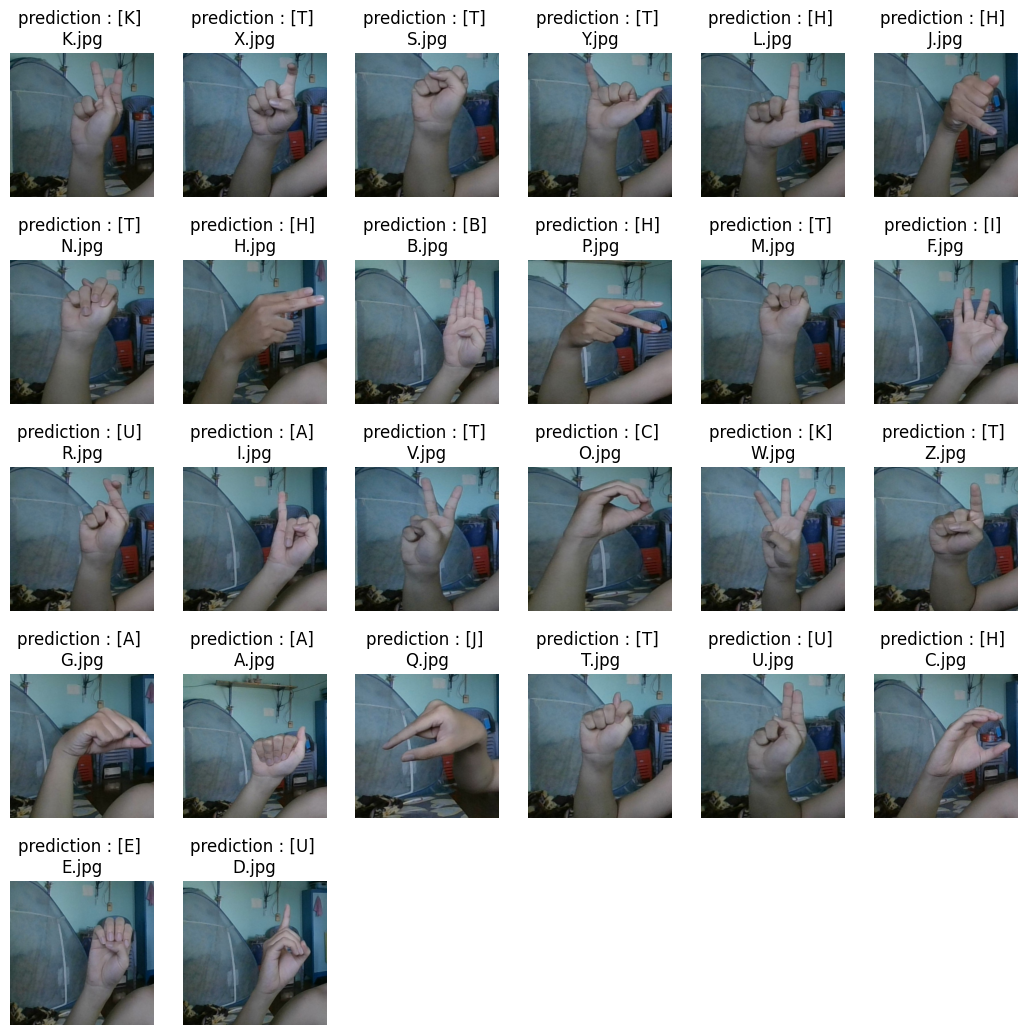

In [34]:
predfigure = plt.figure(figsize = (13,13))
def plot_image_1(fig, image, label, prediction,  row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    title = "prediction : [" + str(prediction) + "] "+ "\n" + label
    plt.title(title)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col-1)):
    plot_image_1(predfigure, test_images[image_index], test_img_names[image_index], test_prediction[image_index], row, col, i)
    image_index = image_index + 1
plt.show()